In [1]:
import cv2
import tensorflow as tf
import h5py
import numpy as np
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

from sketch2code.data_model import *
from sketch2code.datasets import *
from sketch2code.helpers import *
from sketch2code.methods.lstm import *
from sketch2code.methods.rl_env import *
from sketch2code.methods.dqn import *
from sketch2code.methods.dqn_trainer import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

1750 1750


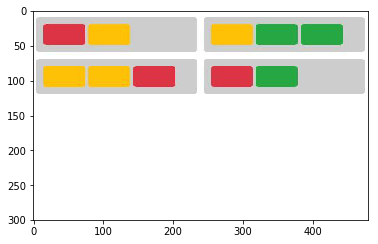

In [4]:
tags, images = load_dataset("toy")
print(len(tags), len(images))
tags, images = tags[:10], images[:10]
images = norm_rgb_imgs(images[:])
plt.imshow(1 - images[0])

In [5]:
env_creator = EnvCreator(tags, images, shrink_factor=0.5, device=device)
env_creator.actions = []
    
for c in ["row", "col-12", "col-6", "col-4", "col-3", "container-fluid", "grey-background"]:
    env_creator.actions.append(AddOpenTagAndClassAction(len(env_creator.actions), "div", (c,)))
    
for c in ["btn-danger", "btn-warning", "btn-success"]:
    env_creator.actions.append(AddOpenTagAndClassAction(len(env_creator.actions), "button", ("btn", c)))

env_creator.actions.append(AddCloseTagAction(len(env_creator.actions)))

In [6]:
envs = env_creator.create()

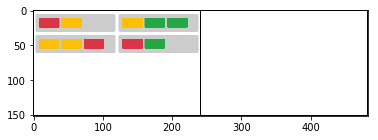

In [7]:
plt.imshow(1 - envs[0].render())

# Train DQN

In [8]:
g = Placeholder()
g.MAX_EPS_LEN = 50

g.BATCH_SIZE = 128
g.GAMMA = 0.999
g.EPS_START = 0.9
g.EPS_END = 0.05
g.EPS_DECAY = 10000
g.TARGET_UPDATE = 10  # per eps
g.POLICY_UPDATE = 10  # per actions

g.DSL_EMBED_DIM = 100
g.DSL_HIDDEN_DIM = 100

g.dsl_vocab = env_creator.vocab
g.n_actions = len(env_creator.actions)
print("n_action:", g.n_actions, ", |dsl_vocab|:", len(g.dsl_vocab))

n_action: 11 , |dsl_vocab|: 19


In [9]:
policy_q = DQN(150, 240, g.dsl_vocab, g.DSL_EMBED_DIM, g.DSL_HIDDEN_DIM, g.n_actions).to(device)
target_q = DQN(150, 240, g.dsl_vocab, g.DSL_EMBED_DIM, g.DSL_HIDDEN_DIM, g.n_actions).to(device)
target_q.load_state_dict(policy_q.state_dict())
target_q.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(
    (word_embedding): Embedding(19, 100, padding_idx=0)
    (lstm): LSTM(100, 100, batch_first=True)
  )
  (head): Linear(in_features=12580, out_features=11, bias=True)
)

In [10]:
env = envs[0]

In [11]:
optimizer = optim.RMSprop(policy_q.parameters())
memory = ReplayMemory(5000)

g.step_done = 0
num_episodes = 5000
accum_rewards = []
accum_done = []

for i_episode in tqdm(range(num_episodes), desc='eps'):
    # Initialize the environment and state
    env.reset()
    accum_rewards.append([])

    for i in tqdm(range(g.MAX_EPS_LEN), desc='actions', disable=True):
        obs = env.obs
        action = select_action(policy_q, env_creator, obs, g, device)
        next_obs, reward, done, _ = env.step(action)    
        
        accum_rewards[-1].append(reward)
        # Store the transition in memory
        memory.push(obs, action.action_id, next_obs, reward, not done)

        # Perform one step of the optimization (on the target network)
        optimize_model(policy_q, target_q, optimizer, env_creator, memory, g, device)
                   
        if done:
            break
            
        if sum(accum_rewards[-1][-7:]) <= env.semantic_penalty * 2:
            # this eps violate two semantic constraint so we stop
            break
    
    accum_done.append(done)
        
    # Update the target network, copying all weights and biases in DQN
    if i_episode % g.TARGET_UPDATE == 0:
        target_q.load_state_dict(policy_q.state_dict())

eps: 100%|██████████| 5000/5000 [29:38<00:00,  2.10it/s]


In [12]:
g.step_done

18801

In [13]:
g.EPS_END + (g.EPS_START - g.EPS_END) * math.exp(-1 * g.step_done / g.EPS_DECAY)

0.17968862038284827

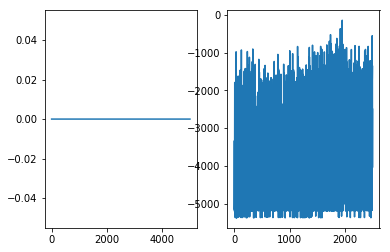

In [14]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(accum_done)
mean_rewards = [np.mean(values) for values in accum_rewards]
ax[1].plot(mean_rewards[::2])
plt.show()

In [15]:
[(i, x) for i, x in enumerate(mean_rewards) if x > 0]

[]

## TEST

In [15]:
print(g.n_actions, len(env_creator.actions))

11 11


In [16]:
env.obs.curr_tag.to_body()

'<div class="col-4"></div>'

In [24]:
[(env_creator.actions[i.action], i.reward) for i in memory.memory]

[(AddCloseTag(), 0),
 (AddOpenTagAndClass(<div class="container-fluid">), 0),
 (AddCloseTag(), 0),
 (AddOpenTagAndClass(<div class="container-fluid">), 0),
 (AddOpenTagAndClass(<button class="btn btn-warning">), -443),
 (AddOpenTagAndClass(<div class="container-fluid">), -5000),
 (AddOpenTagAndClass(<button class="btn btn-warning">), -357),
 (AddCloseTag(), 0),
 (AddCloseTag(), 0),
 (AddCloseTag(), 0),
 (AddOpenTagAndClass(<div class="grey-background">), 2088),
 (AddOpenTagAndClass(<div class="grey-background">), -3940),
 (AddOpenTagAndClass(<div class="grey-background">), -3690),
 (AddOpenTagAndClass(<div class="grey-background">), -1191),
 (AddOpenTagAndClass(<button class="btn btn-danger">), -10801),
 (AddOpenTagAndClass(<div class="grey-background">), -2128),
 (AddOpenTagAndClass(<div class="container-fluid">), -5000),
 (AddCloseTag(), 0),
 (AddOpenTagAndClass(<button class="btn btn-danger">), 3768),
 (AddCloseTag(), 0),
 (AddCloseTag(), 0),
 (AddCloseTag(), -5000),
 (AddCloseTag()

take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddOpenTagAndClass(<button class="btn btn-success">) reward -5362
take action: AddCloseTag() reward 0
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddCloseTag() reward -5000
take action: AddOpenTagAndClass(<button class="btn btn-success">) reward -5373
take action: AddCloseTag() reward 0
take action: AddCloseTag() reward -5000
take action: AddOpenTagAndClass(<button class="btn btn-danger">) reward -5353


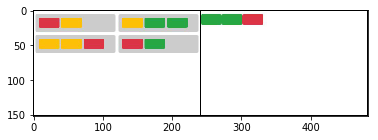

In [21]:
env.reset()
for i in range(g.MAX_EPS_LEN):
    action = select_action(policy_q, env_creator, env.obs, g, device, eps_threshold=0.05)
    next_obs, reward, _, _ = env.step(action)
    print('take action:', action, 'reward', reward)
    if i > 20:
        break
plt.imshow(1 - env.render())

## DEBUG

In [17]:
env.reset()

In [19]:
action = select_action(policy_q, env_creator, env.obs, g, device)
print(action)
print(env.step(action)[0].curr_tag.to_body())

AddOpenTag(<div>)
<div></div>


In [ ]:
plt.imshow(1 - env.render())

In [ ]:
print(env.obs.curr_tag.to_body())
print(env.obs.curr_tag.str_tokens)
print(env.obs.curr_tag.tokens)